In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [37]:
# Load events from Excel
sig_trad = pd.read_excel("/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master-Log_SlideWindow/simulations/test_results/traditional_significant_events.xlsx")
stat_trad = pd.read_excel("/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master-Log_SlideWindow/simulations/test_results/traditional_stationary_events.xlsx")
sig_mcmc = pd.read_excel("/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master-Log_SlideWindow/simulations/test_results/mcmc_significant_events.xlsx")
stat_mcmc = pd.read_excel("/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master-Log_SlideWindow/simulations/test_results/mcmc_stationary_events.xlsx")

In [38]:
wind_df = pd.read_excel("/Users/purbaksengupta/Desktop/Research_Work/rbaTheta-master-Log_SlideWindow/input_data/fall_data.xlsx")
wind_df['DateTime'] = pd.to_datetime(wind_df['DateTime'])
wind_df.set_index('DateTime', inplace=True)
original_series = wind_df.iloc[:, 0]  # assuming 1st column after DateTime

In [82]:
# Original plotting function used above
def plot_events(original_series, sig_df, stat_df, title="Detected Events", save_path=None):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(original_series.index, original_series.values, label="Original Data", color='blue', linewidth=1)

    for _, row in sig_df.iterrows():
        try:
            t1 = int(row['t1'])
            t2 = int(row['t2'])
            start = original_series.index[t1]
            end = original_series.index[t2]
            y1 = row['w_m(t1)']
            y2 = row['w_m(t2)']
            color = 'red' if y2 > y1 else 'green'
            ax.plot([start, end], [y1, y2], color=color, linewidth=2)
        except:
            continue

    for _, row in stat_df.iterrows():
        try:
            t1 = int(row['t1'])
            t2 = int(row['t2'])
            start = original_series.index[t1]
            end = original_series.index[t2]
            y = row['σ_s']
            ax.plot([start, end], [y, y], color='gray', linewidth=2, alpha=0.6)
        except:
            continue

    ax.set_title(title, fontsize=13)
    ax.set_ylabel("Normalized Power")
    ax.set_xlabel("Time")
    ax.grid(True, linestyle="--", alpha=0.3)

    legend_patches = [
        mpatches.Patch(color='blue', label='Original Data'),
        mpatches.Patch(color='red', label='Up-ramp Events'),
        mpatches.Patch(color='green', label='Down-ramp Events'),
        mpatches.Patch(color='gray', label='Stationary Events'),
    ]
    ax.legend(handles=legend_patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15), fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

In [83]:
def plot_events_with_range(original_series, sig_df, stat_df, start_date, end_date, title=None, save_path=None):
    """
    Plots original series and detected events (ramps + stationary) within a time range.
    """
    # === Filter by time range ===
    filtered_series = original_series.loc[start_date:end_date]
    if filtered_series.empty:
        print("⚠️ No data in selected time range.")
        return

    # === Filter event rows falling inside the range ===
    def event_in_range(row):
        try:
            t1 = original_series.index[int(row['t1'])]
            t2 = original_series.index[int(row['t2'])]
            return (t1 >= pd.to_datetime(start_date)) and (t2 <= pd.to_datetime(end_date))
        except:
            return False

    filtered_sig = sig_df[sig_df.apply(event_in_range, axis=1)].copy()
    filtered_stat = stat_df[stat_df.apply(event_in_range, axis=1)].copy()

    # === Plot events ===
    plot_events(filtered_series, filtered_sig, filtered_stat,
                title=title or f"Events ({start_date} to {end_date})",
                save_path=save_path)

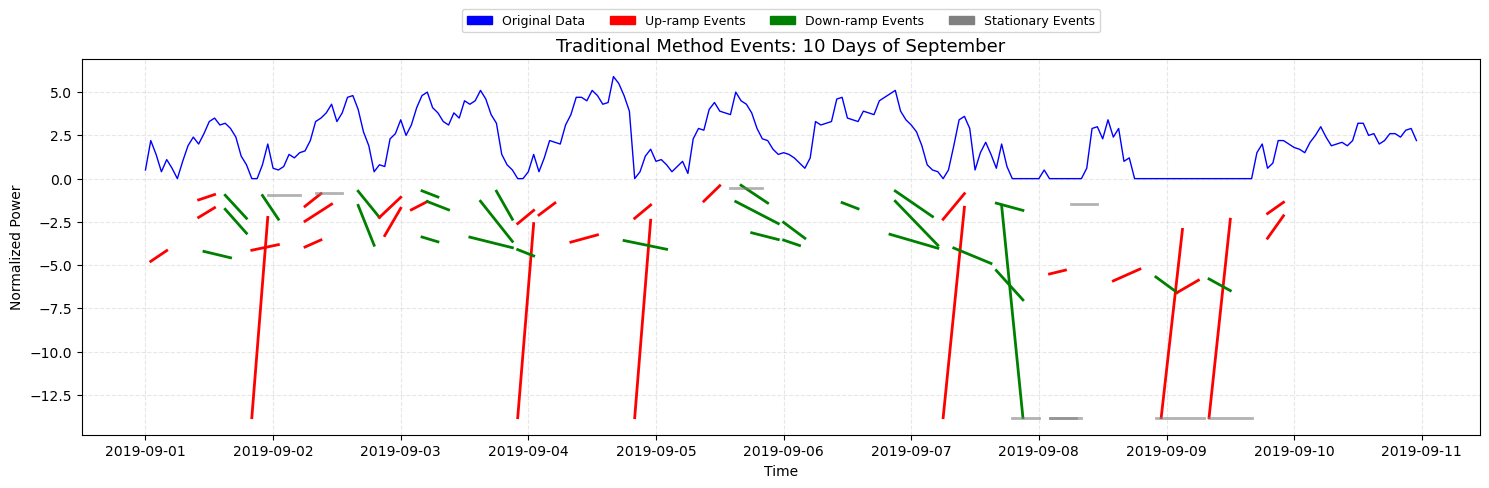

In [46]:
plot_events_with_range(
    original_series,
    sig_trad,
    stat_trad,
    start_date="2019-09-01",
    end_date="2019-09-10",
    title="Traditional Method Events: 10 Days of September"
)

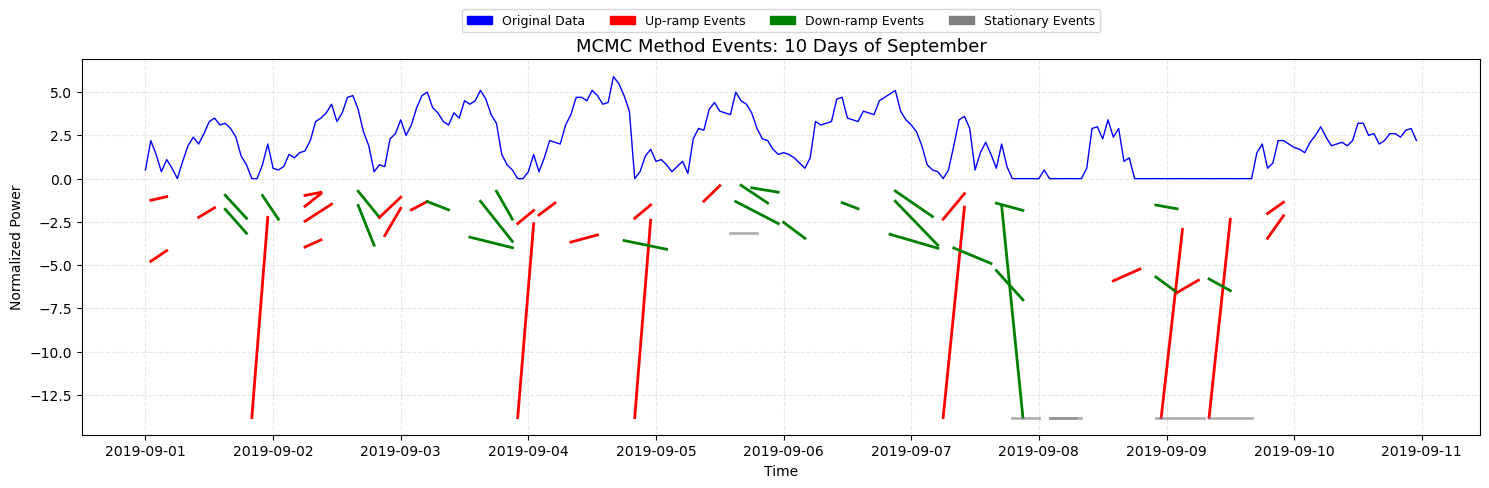

In [47]:
plot_events_with_range(
    original_series,
    sig_mcmc,
    stat_mcmc,
    start_date="2019-09-01",
    end_date="2019-09-10",
    title="MCMC Method Events: 10 Days of September"
)

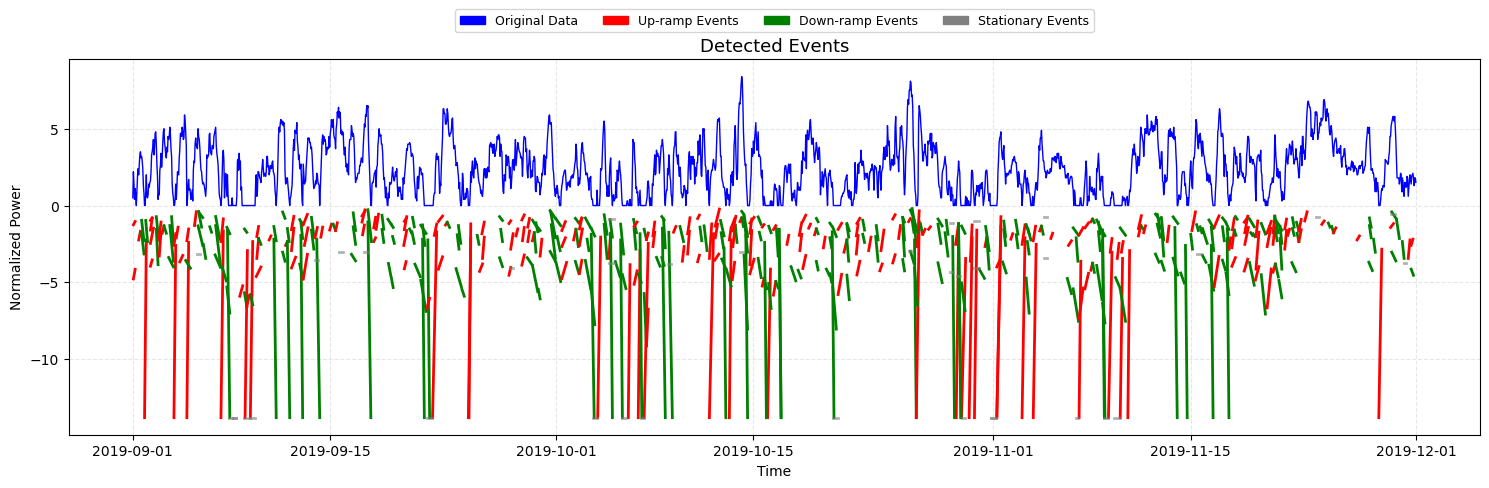

In [45]:
plot_events(original_series, sig_mcmc, stat_mcmc)

In [53]:
def compute_precision_recall_f1(signal_series, sig_events, stat_events, amp_thresh, dur_thresh):
    diffs = signal_series.diff().abs().dropna()
    true_event_indices = set(diffs[diffs >= amp_thresh].index)

    # Filter detected events
    sig_filtered = sig_events[(sig_events['∆w_m'].abs() >= amp_thresh) & (sig_events['∆t_m'] >= dur_thresh)]
    stat_filtered = stat_events[(stat_events['∆t_s'] >= dur_thresh)]

    # Convert to index positions
    detected_indices = set()
    for _, row in sig_filtered.iterrows():
        detected_indices.update(signal_series.index[int(row['t1']): int(row['t2']) + 1])
    for _, row in stat_filtered.iterrows():
        detected_indices.update(signal_series.index[int(row['t1']): int(row['t2']) + 1])

    # Match detected to true event positions
    TP = len([t for t in detected_indices if t in true_event_indices])
    FP = len(detected_indices - true_event_indices)
    FN = len(true_event_indices - detected_indices)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'Amp_Threshold': amp_thresh,
        'Dur_Threshold': dur_thresh,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3),
        'TP': TP,
        'FP': FP,
        'FN': FN
    }

In [62]:
amp_range = [0.09, 0.08, 0.5, 0.07, 0.1, 0.3, 0.5, 0.7, 0.9]
dur_range = [0.8, 0.9, 0.7, 1, 2, 3, 4, 5]

results = []
for amp in amp_range:
    for dur in dur_range:
        score = compute_precision_recall_f1(original_series, sig_trad, stat_trad, amp, dur)
        results.append(score)

grid_df = pd.DataFrame(results)
grid_df.sort_values('F1 Score', ascending=False, inplace=True)
display(grid_df)

,Amp_Threshold,Dur_Threshold,Precision,Recall,F1 Score,TP,FP,FN
13,0.08,3.0,0.834,0.790,0.811,1455,290,387
12,0.08,2.0,0.834,0.790,0.811,1455,290,387
11,0.08,1.0,0.834,0.790,0.811,1455,290,387
10,0.08,0.7,0.834,0.790,0.811,1455,290,387
9,0.08,0.9,0.834,0.790,0.811,1455,290,387
...,...,...,...,...,...,...,...,...
67,0.90,1.0,0.157,0.550,0.244,183,984,150
69,0.90,3.0,0.157,0.550,0.244,183,984,150
68,0.90,2.0,0.157,0.550,0.244,183,984,150
70,0.90,4.0,0.150,0.480,0.229,160,907,173


In [74]:
compute_precision_recall_f1(original_series, sig_trad, stat_trad, amp_thresh=0.09, dur_thresh=3)

{'Amp_Threshold': 0.09,
 'Dur_Threshold': 3,
 'Precision': 0.834,
 'Recall': 0.79,
 'F1 Score': 0.811,
 'TP': 1455,
 'FP': 290,
 'FN': 387}

In [78]:
amp_range = [0.09, 0.1, 0.3, 0.5, 0.7, 0.9]
dur_range = [2, 3, 4, 5]

# Traditional
trad_results = []
for amp in amp_range:
    for dur in dur_range:
        score = compute_precision_recall_f1(original_series, sig_trad, stat_trad, amp, dur)
        score['Method'] = 'Traditional'
        trad_results.append(score)

grid_df = pd.DataFrame(trad_results)

# MCMC
mcmc_results = []
for amp in amp_range:
    for dur in dur_range:
        score = compute_precision_recall_f1(original_series, sig_mcmc, stat_mcmc, amp, dur)
        score['Method'] = 'MCMC'
        mcmc_results.append(score)

mcmc_df = pd.DataFrame(mcmc_results)

# Combine both
combined_df = pd.concat([grid_df, mcmc_df], ignore_index=True)
combined_df.sort_values(['F1 Score', 'Method'], ascending=[False, True], inplace=True)

# Display top results
display(combined_df)

,Amp_Threshold,Dur_Threshold,Precision,Recall,F1 Score,TP,FP,FN,Method
0,0.09,2,0.834,0.790,0.811,1455,290,387,Traditional
1,0.09,3,0.834,0.790,0.811,1455,290,387,Traditional
4,0.10,2,0.793,0.793,0.793,1383,362,360,Traditional
5,0.10,3,0.793,0.793,0.793,1383,362,360,Traditional
2,0.09,4,0.823,0.664,0.735,1223,263,619,Traditional
6,0.10,4,0.780,0.665,0.718,1159,327,584,Traditional
24,0.09,2,0.821,0.634,0.715,1167,254,675,MCMC
25,0.09,3,0.821,0.634,0.715,1167,254,675,MCMC
28,0.10,2,0.780,0.636,0.700,1108,313,635,MCMC
29,0.10,3,0.780,0.636,0.700,1108,313,635,MCMC


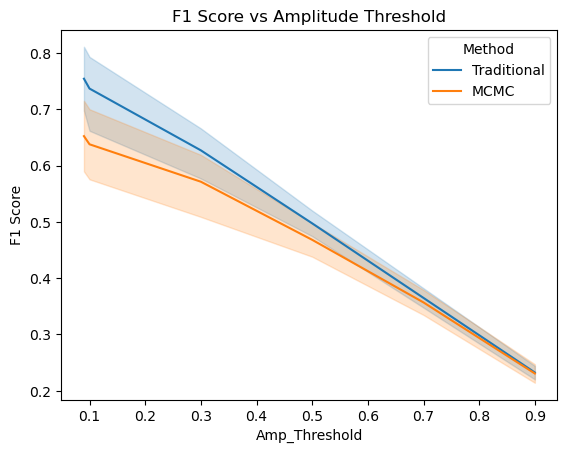

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=combined_df, x='Amp_Threshold', y='F1 Score', hue='Method')
plt.title('F1 Score vs Amplitude Threshold')
plt.show()